# データ作成

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import random
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 画素の位置を適当に入れ替える
SHUFFLED_INDICES = list(range(14*14))
random.shuffle(SHUFFLED_INDICES)
map_dict = {new_id: orig_id for new_id, orig_id in enumerate(SHUFFLED_INDICES)} # どのように入れ替わったかを示す dict {to: from}

class RandomShuffle(object):
    def __call__(self, tensor):
        reshaped_tensor = tensor.view(-1)  # 1次元テンソルに変換
        
        # シャッフルされたインデックスを使用してピクセルの順序を入れ替える
        shuffled_tensor = reshaped_tensor[SHUFFLED_INDICES]
        
        # シャッフル後のテンソルを元の形状に変形して返す
        return shuffled_tensor.view(tensor.size())
        
# データの前処理
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    RandomShuffle(),
])

# MNISTデータセットの読み込み
original_train_dataset = MNIST(root="./data", train=True, transform=transform, download=True)
original_test_dataset = MNIST(root="./data", train=False, transform=transform, download=True)


In [2]:
# クラス1のデータのみ抽出
train_dataset = [data for data in original_train_dataset if data[1] == 1]
test_dataset = [data for data in original_test_dataset if data[1] == 1]

In [3]:
# データ数を100に制限
train_dataset = train_dataset[:100]
test_dataset = test_dataset[:100]

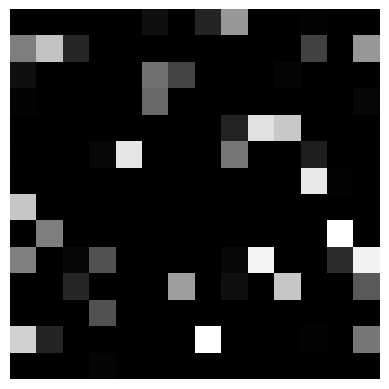

In [4]:
import matplotlib.pyplot as plt
image = train_dataset[0][0].squeeze(0)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
len(train_dataset)

100

In [6]:
len(test_dataset)

100

## ベクトル作成

In [48]:
def timeseries_to_elementwise_vectors(dataset):
    tensors = [torch.flatten(d[0]) for d in dataset]
    mat = torch.stack(tensors, dim=1)
    
    # 次元ごとに取り出す
    dimwise_tensors = torch.unbind(mat)
    
    # リストに格納する
    dimwise_tensor_list = list(dimwise_tensors)

    # numpy に変換
    dimwise_tensors_np = [ t.numpy() for t in dimwise_tensor_list]

    return np.array(dimwise_tensors_np)


In [52]:
train_vectors = timeseries_to_elementwise_vectors(train_dataset)
train_vectors.shape

(196, 100)

## 可視化

In [69]:
def id_to_dist_from_center(id: int, side_length=14) -> float:
    """画素のidをもとに中心からの距離を計算する"""
    col = id % side_length
    row = id // side_length

    center = (side_length - 1) / 2

    return ((col-center)**2 + (row-center)**2)**0.5

<Axes: xlabel='x', ylabel='y'>

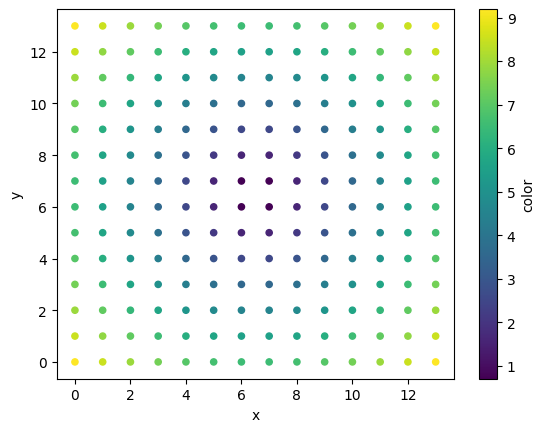

In [94]:
side_length = 14
df = pd.DataFrame(
    data = {
        "x": [i for i in range(side_length)] * side_length,
        "y": [i for i in range(side_length) for _ in range(side_length)],
        "color": [id_to_dist_from_center(i, side_length=side_length) for i in range(side_length*side_length)]
    }
)
df.plot.scatter(x='x', y='y', c="color", colormap='viridis')

In [129]:
def vis(dataset):
    vectors = timeseries_to_elementwise_vectors(dataset)
    tsne = TSNE(n_components=2, random_state=0, perplexity=25.0)
    embeddings_2d = tsne.fit_transform(vectors)

    # 中心からの距離に基づき可視化
    df = pd.DataFrame(
        data={
            "x": embeddings_2d[:, 0],
            "y": embeddings_2d[:, 1],
            "color": [id_to_dist_from_center(map_dict[id], side_length=14) for id in range(embeddings_2d.shape[0])]
        }
    )
    df.plot.scatter(x='x', y='y', c="color", colormap='viridis')

    # ベクトルの非ゼロ要素の数に基づき可視化
    df = pd.DataFrame(
        data={
            "x": embeddings_2d[:, 0],
            "y": embeddings_2d[:, 1],
            "color": [np.count_nonzero(vectors[id]) for id in range(embeddings_2d.shape[0])]
        }
    )
    df.plot.scatter(x='x', y='y', c="color", colormap='viridis')

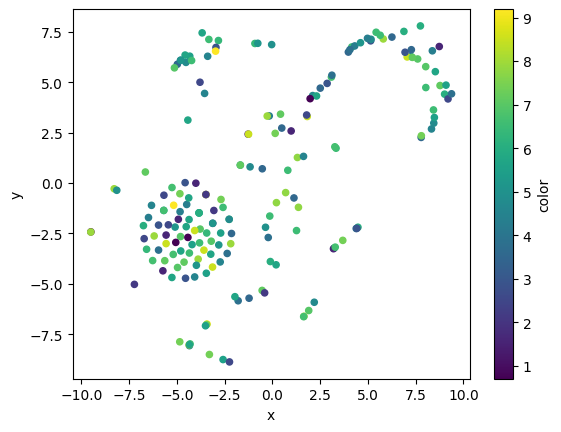

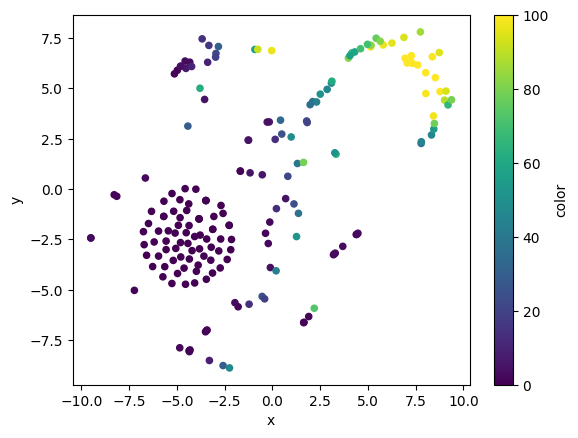

In [130]:
vis(train_dataset)

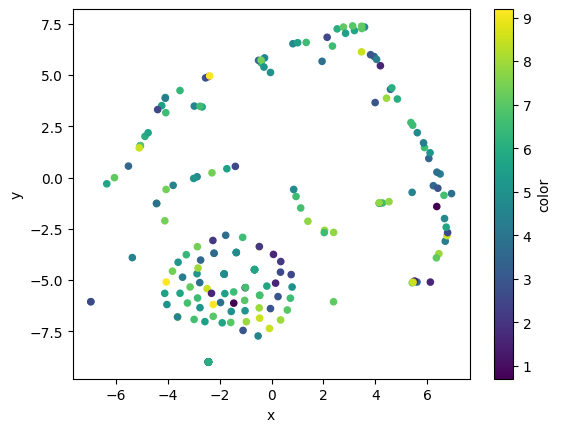

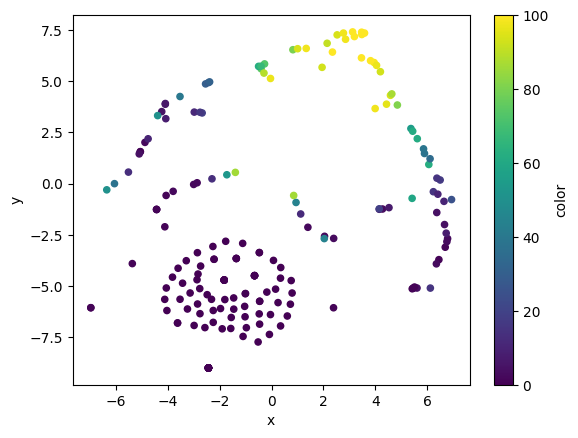

In [131]:
vis(test_dataset)

In [7]:
label1_data = test_dataset[:100]

In [8]:
label7_data = [data for data in original_test_dataset if data[1] == 7][:100]

In [9]:
target_data = label1_data + label7_data

In [14]:
from PIL import Image, ImageDraw, ImageFont
pil_imgs = []
for t, data in enumerate(target_data):
    image, _ = data
    canvas = Image.new(mode="RGB", size=(300,320), color=(255,255,255))

    pil_img = transforms.functional.to_pil_image(image)
    pil_img = pil_img.resize((300,300))
    
    canvas.paste(pil_img, (0,0))
    
    draw = ImageDraw.Draw(canvas)
    draw.text((150, 310), f't={t}', fill='black', align="center")

    pil_imgs.append(canvas)

pil_imgs[0].save('exp2.gif',save_all=True, append_images=pil_imgs[1:],optimize=True, duration=100, loop=0)

In [10]:
losses = [ loss_fn(model, d[0].unsqueeze(0)).item() for d in target_data]

In [11]:
import pandas as pd

df = pd.DataFrame(
    data = {
        "loss": losses
    }
)

<Axes: >

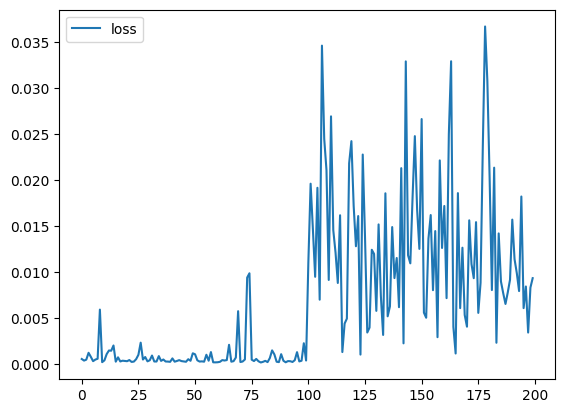

In [12]:
df.plot()